In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from data_prep import fetch_data, interpolate, set_target, backstep_columns, train_test_split

In [35]:
df = fetch_data()
df = interpolate(df)
df = set_target(df, 1)
df

,EURO,AT,BE,CY,CZ,DE,DK,EA,EL,ES,...,LU,LV,MT,NL,PL,PT,SE,SK,UK,target
day,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.984700,5.55,5.680000,0.000000,0.000000,5.390000,5.7100,5.550000,6.520000,5.630000,...,5.560000,0.000000,0.000000,5.61,0.000000,5.610000,5.860000,0.00,0.000000,0
2000-01-04,0.970000,5.71,5.730000,0.000000,0.000000,5.530000,5.8200,5.630000,6.630000,5.730000,...,5.560000,0.000000,0.000000,5.62,0.000000,5.780000,5.890000,0.00,5.740000,0
2000-01-05,0.967600,5.71,5.720000,0.000000,0.000000,5.500000,5.8100,5.620000,6.610000,5.720000,...,5.560000,0.000000,0.000000,5.62,0.000000,5.790000,5.890000,0.00,5.830000,1
2000-01-06,0.968600,5.71,5.770000,0.000000,0.000000,5.540000,5.8600,5.660000,6.610000,5.710000,...,5.660000,0.000000,0.000000,5.68,0.000000,5.840000,5.885000,0.00,5.840000,1
2000-01-07,0.971400,5.71,5.730000,0.000000,0.000000,5.490000,5.8100,5.610000,6.610000,5.710000,...,5.660000,0.000000,0.000000,5.60,0.000000,5.740000,5.880000,0.00,5.780000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26,0.900700,-0.03,0.023333,0.560000,1.590000,-0.272500,-0.2125,0.250000,1.426667,0.415714,...,-0.206667,0.147500,0.417500,-0.11,2.070000,0.410000,0.107500,0.14,0.770000,0
2019-12-27,0.894900,-0.03,0.020000,0.560000,1.590000,-0.270000,-0.2100,0.240000,1.430000,0.410000,...,-0.210000,0.150000,0.420000,-0.11,2.070000,0.390000,0.110000,0.14,0.760000,0
2019-12-28,0.893767,-0.01,0.036667,0.573333,1.593333,-0.256667,-0.2100,0.253333,1.440000,0.420000,...,-0.190000,0.153333,0.423333,-0.09,2.083333,0.406667,0.123333,0.14,0.796667,0


In [38]:
targets = df['target']
features = df.drop('target', axis=1)

# Preprocessing

## Scale data

In [39]:
from sklearn.preprocessing import MinMaxScaler

In [40]:
scaler = MinMaxScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(features), columns = features.columns)

## Reshape Data

In [41]:
backsteps = 10
shaped_features = backstep_columns(scaled_features, backsteps)
targets = targets[backsteps:]
assert shaped_features.shape[0] == targets.shape[0]
# shaped_test = backstep_columns(scaled_test, ['EURO', 'POUND'], 5)


In [42]:
shaped_features.shape

(7292, 11, 25)

## Train test Split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(shaped_features, targets, percentile=0.5)

## Convert to Pytorch Data

In [44]:
from model_utils import BasicData
from torch.utils.data import DataLoader
from torch import nn
import torch

In [45]:
X_train.shape, y_train.shape

((3646, 11, 25), (3646,))

In [46]:
X_test.shape, y_test.shape

((3646, 11, 25), (3646,))

In [47]:
training_data = BasicData(X_train, y_train)
test_data = BasicData(X_test, y_test)
train_loader = DataLoader(training_data, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True, drop_last=True)

In [48]:
from model_utils import train_net, pred_accuracy, LSTM
from plotting_utils import plot_train_test

In [ ]:
model = LSTM(25, 5, 1, 1)
# model.forward(next(iter(train_loader))[0]).shape

In [ ]:
train_history, test_history = train_net(
    model, train_loader, test_data, loss_fn=torch.nn.BCEWithLogitsLoss(), epochs=100, learning_rate=0.01)
plot_train_test(train_history, test_history)

In [90]:
pred_accuracy(model(test_data.x).squeeze(), test_data.y)

tensor(0.5091)

In [114]:
model = LSTM(25, 5, 5, 1)

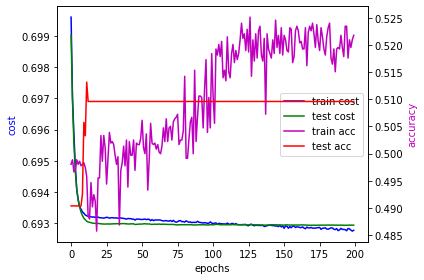

In [115]:
train_history, test_history = train_net(
    model, train_loader, test_data, loss_fn=torch.nn.BCEWithLogitsLoss(), epochs=200, learning_rate=0.01)
plot_train_test(train_history, test_history)

In [116]:
pred_accuracy(model(test_data.x).squeeze(), test_data.y)

tensor(0.5096)

In [117]:
model = LSTM(2, 5, 10, 1)

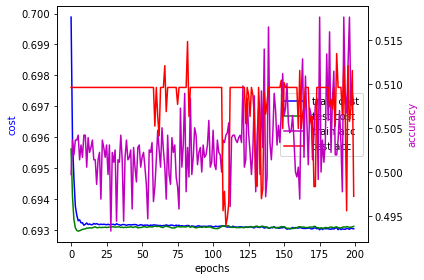

In [118]:
train_history, test_history = train_net(
    model, train_loader, test_data, loss_fn=torch.nn.BCEWithLogitsLoss(), epochs=200, learning_rate=0.01)


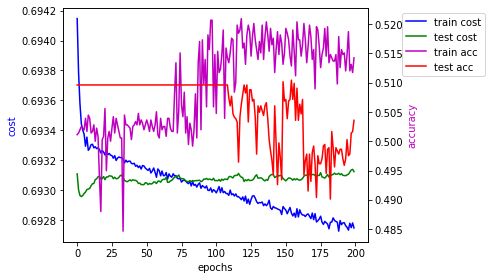

In [126]:
model = LSTM(2, 5, 5, 1)
train_history, test_history = train_net(
    model, train_loader, test_data, loss_fn=torch.nn.BCEWithLogitsLoss(), epochs=200, learning_rate=0.01)
plot_train_test(train_history, test_history)